In [16]:
import os
import pickle
import random
import re
import string
import warnings

import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from scipy import stats
from sklearn import preprocessing, utils
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from wordcloud import WordCloud
from xgboost import XGBRegressor


warnings.filterwarnings('ignore')

In [17]:
#Exploratory Data Analysis

In [18]:
df = pd.read_csv(r'C:\Users\Warrior\Downloads\google-quest-challenge\train.csv')
df.head(5)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,...,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


In [19]:
train_cols = ['qa_id', 'question_title', 'question_body', 'question_user_name',
       'question_user_page', 'answer', 'answer_user_name', 'answer_user_page',
       'url', 'category', 'host']

X = df[train_cols]
y = df.drop(columns=train_cols)

In [20]:
X.head(2)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com


In [21]:
y.head(2)

,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,1.0,0.333333,0.0,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.0,0.000000,1.000000
1,1.0,1.000000,0.0,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.0,0.666667,0.888889


In [22]:
question_related_aspects = []
answer_related_aspects = []

for col in y.columns:
    if 'question' in col:
        question_related_aspects.append(col)
    else:
        answer_related_aspects.append(col)

print(f'Aspects related to question : {len(question_related_aspects)} - {question_related_aspects}')
print()
print(f'Aspects related to answer : {len(answer_related_aspects)} - {answer_related_aspects}')

Aspects related to question : 21 - ['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written']

Aspects related to answer : 9 - ['answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written']


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print('X_train Shape : ', X_train.shape)
print('X_test Shape :', X_test.shape)
print('y_train Shape :', y_train.shape)
print('y_test Shape :', y_test.shape)

X_train Shape :  (4863, 11)
X_test Shape : (1216, 11)
y_train Shape : (4863, 30)
y_test Shape : (1216, 30)


In [24]:
categorical_features = ['qa_id', 'question_user_name', 'question_user_page', 'answer_user_name',
                         'answer_user_page', 'url', 'category', 'host']

for i in categorical_features:
    print(f'Cadinality of feature {i} - {X[i].nunique()}')

Cadinality of feature qa_id - 6079
Cadinality of feature question_user_name - 3215
Cadinality of feature question_user_page - 3422
Cadinality of feature answer_user_name - 4114
Cadinality of feature answer_user_page - 4430
Cadinality of feature url - 3583
Cadinality of feature category - 5
Cadinality of feature host - 63


In [25]:
X_train = X_train[['question_title', 'question_body', 'answer', 'category', 'host']]
X_test = X_test[['question_title', 'question_body', 'answer', 'category', 'host']]

In [26]:
miss = len(X_train['category'].isnull())
total = len(X_train['category'])

print(f"Number of NULL values in train data, category column is {miss} out if {total}. Percent of missing value: {(total-miss)/total}%.")

miss = len(X_test['category'].isnull())
total = len(X_test['category'])

print(f"Number of NULL values in test data, category column is {miss} out if {total}. Percent of missing value: {(total-miss)/total}%.")



Number of NULL values in train data, category column is 4863 out if 4863. Percent of missing value: 0.0%.
Number of NULL values in test data, category column is 1216 out if 1216. Percent of missing value: 0.0%.


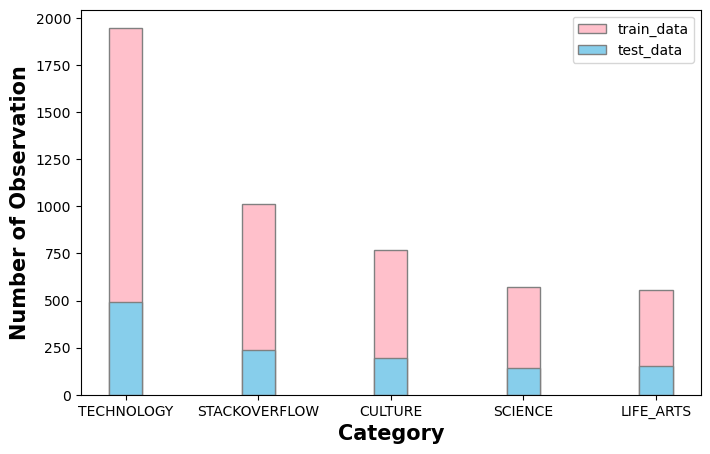

In [27]:
#set width bar
barWidth = 0.25
fig = plt.subplots(figsize=(8, 5))

#set height of bar
train_data_category = X_train['category'].value_counts()
#print(train_data_category)

test_data_category = X_test['category'].value_counts()
test_data_category = test_data_category.loc[train_data_category.index]
#print(test_data_category)

#set position of bar on X axis
br1 = np.arange(len(train_data_category))
br2 = [x for x in br1]

#make the plot
plt.bar(br1, train_data_category, color='#FFC0CB', width=barWidth, edgecolor='grey', label = 'train_data')
plt.bar(br2, test_data_category, color='#87CEEB', width=barWidth, edgecolor='grey', label='test_data')

#Adding Xticks
plt.xlabel('Category', fontweight ='bold', fontsize = 15)
plt.ylabel('Number of Observation', fontweight ='bold', fontsize = 15)
plt.xticks([r for r in range(len(train_data_category))], train_data_category.index)

plt.legend()
plt.show()

In [28]:
miss = len(X_train['host'].isnull())
total = len(X_train['host'])
print(f"Number of NULL Values in train data, host column is {miss} out if {total}. Percent of missing value: {(total-miss)/total}%.")

miss = len(X_test['host'].isnull())
total = len(X_test['host'])
print(f"Number of NULL Values in test data, host column is {miss} out if {total}. Percent of missing value: {(total-miss)/total}%.")



Number of NULL Values in train data, host column is 4863 out if 4863. Percent of missing value: 0.0%.
Number of NULL Values in test data, host column is 1216 out if 1216. Percent of missing value: 0.0%.


In [29]:
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490

def decontracted(phrase):
    phrase = re.sub(r"(W|w)on(\'|\’)t ", "will not ", phrase)
    phrase = re.sub(r"(C|c)an(\'|\’)t ", "can not ", phrase)
    phrase = re.sub(r"(Y|y)(\'|\’)all ", "you all ", phrase)
    phrase = re.sub(r"(Y|y)a(\'|\’)ll ", "you all ", phrase)
    phrase = re.sub(r"(I|i)(\'|\’)m ", "i am ", phrase)
    phrase = re.sub(r"(A|a)isn(\'|\’)t ", "is not ", phrase)
    phrase = re.sub(r"n(\'|\’)t ", " not ", phrase)
    phrase = re.sub(r"(\'|\’)re ", " are ", phrase)
    phrase = re.sub(r"(\'|\’)d ", " would ", phrase)
    phrase = re.sub(r"(\'|\’)ll ", " will ", phrase)
    phrase = re.sub(r"(\'|\’)t ", " not ", phrase)
    phrase = re.sub(r"(\'|\’)ve ", " have ", phrase)
    return phrase

def clean_text(x):
    x = str(x)
    for punct in "/-'":
        x = x.replace(punct, ' ')
    for punct in '&':
        x = x.replace(punct, f' {punct} ')
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, '')
    return x

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '12345', x)
    x = re.sub('[0-9]{4}', '1234', x)
    x = re.sub('[0-9]{3}', '123', x)
    x = re.sub('[0-9]{2}', '12', x)
    return x

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = clean_text(sentance)
        sent = clean_numbers(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(stemmer.stem(e) for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text


def special_symbols(string):
    pattern = r'[^a-zA-Z0-9\s]'
    matches = re.finditer(pattern, string, re.MULTILINE)
    return len([_ for _ in matches])

In [30]:
def no_of_vowels_and_consonants(str):
    vowel = {'a','e','i','o','u'}
    consonant = set(string.ascii_lowercase) - vowel

    def count_letters(lst, set_):
        return sum([1 for i in lst if i in set_])
    
    vowels_count = count_letters(list(str), vowel)
    consonants_count = count_letters(list(str), consonant)
    total = vowels_count + consonants_count + 1
    return [vowels_count/total, consonants_count/total] #ratio



In [31]:
def no_of_nouns(str):
    tokens = nltk.word_tokenize(str.lower())
    text = nltk.Text(tokens)
    tags = nltk.pos_tag(text)
    return sum([1 for word,pos in tags if 'NN' in pos])

In [32]:

#######################################################################################################
X_train['preprocessed_question_title'] = preprocess_text(X_train['question_title'].values)
X_train['preprocessed_question_body'] = preprocess_text(X_train['question_body'].values)
X_train['preprocessed_answer'] = preprocess_text(X_train['answer'].values)
#######################################################################################################
X_test['preprocessed_question_title'] = preprocess_text(X_test['question_title'].values)
X_test['preprocessed_question_body'] = preprocess_text(X_test['question_body'].values)
X_test['preprocessed_answer'] = preprocess_text(X_test['answer'].values)
#######################################################################################################
X_train['question_title_length'] = X_train['preprocessed_question_title'].apply(lambda x: len(x.split()))
X_test['question_title_length'] = X_test['preprocessed_question_title'].apply(lambda x: len(x.split()))
#######################################################################################################
X_train['question_body_length'] = X_train['preprocessed_question_body'].apply(lambda x: len(x.split()))
X_test['question_body_length'] = X_test['preprocessed_question_body'].apply(lambda x: len(x.split()))
#######################################################################################################
X_train['answer_length'] = X_train['preprocessed_answer'].apply(lambda x: len(x.split()))
X_test['answer_length'] = X_test['preprocessed_answer'].apply(lambda x: len(x.split()))
#######################################################################################################
X_train['question_title_special_symbols'] = X_train['question_title'].apply(special_symbols)
X_train['question_body_special_symbols'] = X_train['question_body'].apply(special_symbols)
X_train['answer_special_symbols'] = X_train['answer'].apply(special_symbols)
#######################################################################################################
X_test['question_title_special_symbols'] = X_test['question_title'].apply(special_symbols)
X_test['question_body_special_symbols'] = X_test['question_body'].apply(special_symbols)
X_test['answer_special_symbols'] = X_test['answer'].apply(special_symbols)
#######################################################################################################

  0%|          | 0/4863 [00:00<?, ?it/s]

100%|██████████| 1216/1216 [00:03<00:00, 357.63it/s]


In [33]:
X_train.head()

,question_title,question_body,answer,category,host,preprocessed_question_title,preprocessed_question_body,preprocessed_answer,question_title_length,question_body_length,answer_length,question_title_special_symbols,question_body_special_symbols,answer_special_symbols
861,Get raw output from web server,For research I am looking to get the actual ra...,Add the --save-headers option to the wget comm...,TECHNOLOGY,serverfault.com,get raw output web server,research look get actual raw output apach send...,add save header option wget command line,5,41,7,0,21,4
2576,"How to prevent the ""Too awesome to use"" syndrome",When you give the player a rare but powerful i...,Short Answer: \n\nHave something more valuable...,TECHNOLOGY,gamedev.stackexchange.com,prevent awesom use syndrom,give player rare power item use never realli r...,short answer someth valuabl item player lose h...,4,62,177,2,18,46
903,High ping on games while streaming,I'm streaming with Elgato Capture Card to Twit...,The problem is you upload speed =(. When you a...,CULTURE,gaming.stackexchange.com,high ping game stream,stream elgato captur card twitch get high ping...,problem upload speed stream send lot data ping...,4,15,30,0,7,13
2534,How to check image is loaded completely or not...,I m trying to execute some code when image is ...,You can use the onLoad event\n\n&lt;script lan...,STACKOVERFLOW,stackoverflow.com,check imag load complet not use javascript fac...,tri execut code imag not load use follow code ...,use onload event lt script languag javascript ...,8,31,20,0,34,27
109,Facebook Connect Changed My User ID and Delete...,So this actually happened a long time ago I ju...,This isn't possible without hours of painful d...,TECHNOLOGY,meta.stackexchange.com,facebook connect chang user id delet badg,actual happen long time ago never complain bet...,possibl without hour pain dev work manual mani...,7,51,19,0,28,6
